# load library

In [1]:
### visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import matplotlib as mat
py.init_notebook_mode(connected=True)

In [2]:
# data analysis and wrangling
import numpy as np
import pandas as pd
#import re
from functools import partial

In [3]:
# other library
import datetime
import calendar

In [4]:
# ignore sys warning
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# Cohort analysis

cohort analysis 幫助我們觀察消費者的回購狀況，透過它我們可以迅速發現回購異狀，並以此做更深入的分析，比如比較來源渠道、訂單內容等等。
在這一篇 Jupyter 中，我要示範以 python 畫出cohort table。

## load data from csvs

由於訂單資料很龐大，因此我先透過 API 將訂單資訊載入到本機端(這一步沒有呈現在這邊)，然後用 for loop 將每個月的訂單 csv 檔案載入並儲存成一個data frame。

In [5]:
path =r'YOUR PATH' 
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df_temp = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df_temp)
df = pd.concat(list_)

## spilt cart by different shop

由於訂單資訊並不會分商城儲存，因此我們必須先將不同商城的資訊拆開

In [6]:
df = df.loc[df.order_status != 'Cancel']
df_10706 = df.loc[df.shop_id == 10706].reset_index().drop('index', axis=1)
del df
#df_10706.head(3)

## TS to TG

由於訂單資訊包含商品資訊，因此會出現單筆訂單多個商品(列)的情況，由於cohort table並不需要商品資訊，因此我們將去除商品資訊與去除重複訂單資訊。

In [7]:
df_10706_tg = df_10706[['cart_code', 'member_code', 'order_time', 'order_label', 
                        'payment', 'promotion_discount', 'ecoupon_discount']]

#df_10706_tg.head(3)

In [8]:
df_10706_tg = df_10706_tg.groupby(['cart_code', 'member_code', 'order_time', 'order_label'], as_index=False).sum()
df_10706_tg = df_10706_tg.drop_duplicates()
#df_10706_tg.head(3)

下面我們要處理時間資訊，由於原始資料的時間資訊細至毫秒，但是計算cohort table時，我們僅需到月的資訊，因此我們將訂購時間抓至月份。

In [9]:
df_10706_tg['order_time'] = df_10706_tg['order_time'].str[:7]
df_10706_tg['order_time'] = pd.to_datetime(df_10706_tg['order_time'], format='%Y-%m-%d')
#df_10706_tg.head(3)

## Find first buy day

計算cohort的第一步在於先找出每位消費者第一次購買的月份，如此我們才可以根據消費者的首購月份計算每個 m + n 的回購

In [10]:
df_10706_tg = pd.merge(df_10706_tg,
                       df_10706_tg.groupby('member_code', as_index=False)['order_time'].min(), 
                       'left',
                       'member_code')
df_10706_tg.columns = ['cart_code', 'member_code', 'order_time', 'order_label', 'payment', 
                       'promotion_discount', 'ecoupon_discount', 'first_buy']
#df_10706_tg.head(3)

## define cohort_group & order_period

將訂購日期與首購日期轉換成月份，如此方便我們計算cohort

In [11]:
df_10706_tg['cohort_group'] = df_10706_tg.first_buy.astype(str).str[:7] 
df_10706_tg['order_period'] = df_10706_tg.order_time.astype(str).str[:7]
#df_10706_tg.head(3)

## calculate each cohort_group & order_period metrics

在這邊我們要分別計算每群不同首購月份的族群在不同月份的貢獻，這邊我們會特別計算人數與訂單數

In [12]:
cohorts = df_10706_tg.groupby(['cohort_group', 'order_period']).agg({'member_code': pd.Series.nunique,
                                                                     'cart_code': pd.Series.nunique})

# make the column names more meaningful
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head()

member_code  cart_code
cohort_group order_period                        
2016-12      2016-12               137        140
             2017-01                18         25
             2017-02                19         20
             2017-03                19         28
             2017-04                15         18

## label cohort period

這邊我們要將每個月份依照不同的首購月份給予編號，以便我們方便比較。比如對比11月和12月的回購狀況，10月m+1和11月m+1的比較反而更直覺

In [13]:
cohorts['period'] = cohorts.groupby(level=0).cumcount()
cohorts.head()

member_code  cart_code  period
cohort_group order_period                                
2016-12      2016-12               137        140       0
             2017-01                18         25       1
             2017-02                19         20       2
             2017-03                19         28       3
             2017-04                15         18       4

## reindex cohort

這邊我們將以剛重新計算的編號來取代原先的編號

In [14]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'period'], inplace=True)
cohorts.head()

order_period  member_code  cart_code
cohort_group period                                     
2016-12      0           2016-12          137        140
             1           2017-01           18         25
             2           2017-02           19         20
             3           2017-03           19         28
             4           2017-04           15         18

## calculate user retention by cohort

這邊開始我們要根據回購人來計算cohort table，後續我們還會根據訂單數來做一次，詳細說明僅會在這邊呈現。
首先我們先取得首購月份的總人數

In [15]:
cohorts_usr_group = cohorts['member_code'].groupby(level=0).first()
cohorts_usr_group.head()

cohort_group
2016-12     137
2017-01     618
2017-02     658
2017-03    1267
2017-04    1244
Name: member_code, dtype: int64

再來我們先將 cohorts 以剛得到的總人數來計算各個月分的回購比例

In [16]:
cohorts_usr = cohorts['member_code'].unstack(0)                  #將cohort_group作為欄位
cohorts_usr = cohorts_usr.divide(cohorts_usr_group, axis=1)      #計算每個月回購率
cohorts_usr.head()

cohort_group,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10
period,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.131387,0.114887,0.148936,0.140489,0.127010,0.120062,0.124558,0.124834,0.124312,0.102093,NaN
2,0.138686,0.129450,0.112462,0.112865,0.091640,0.093726,0.086341,0.110226,0.093627,NaN,NaN
3,0.138686,0.106796,0.113982,0.086030,0.073955,0.068164,0.090587,0.096282,NaN,NaN,NaN
4,0.109489,0.100324,0.072948,0.061563,0.069132,0.082881,0.065817,NaN,NaN,NaN,NaN


## 畫出不同首購月份的回購線圖

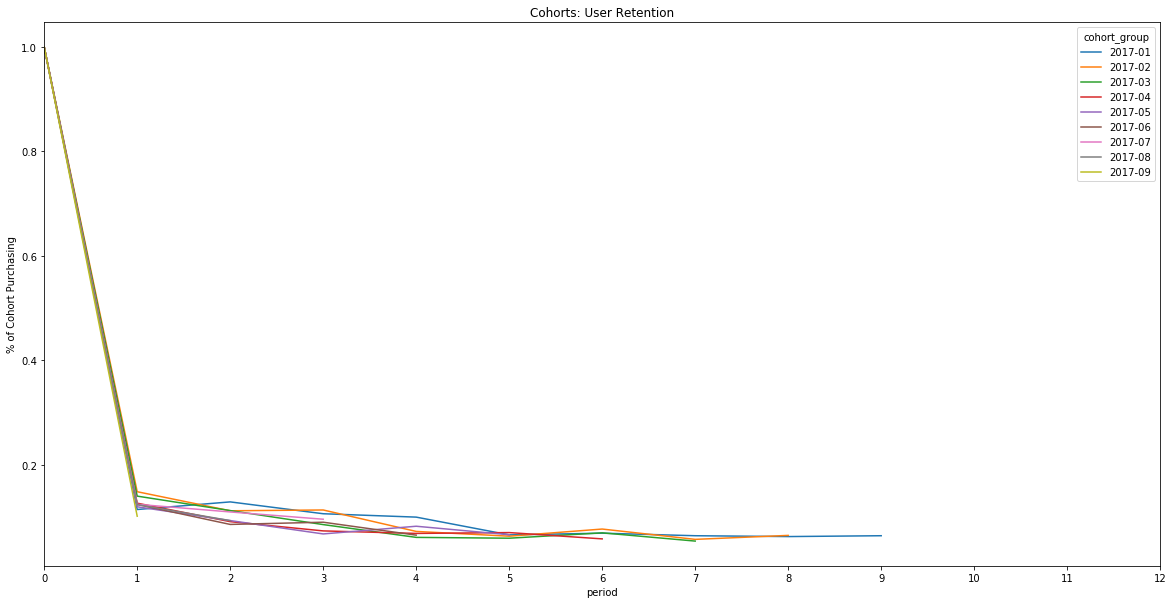

In [17]:
cohorts_usr[['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09']].plot(figsize=(20,10))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(0, 12.1, 1))
plt.xlim(0, 12)
#plt.ylim(0, 0.2)
plt.ylabel('% of Cohort Purchasing')

## 呈現 cohort table

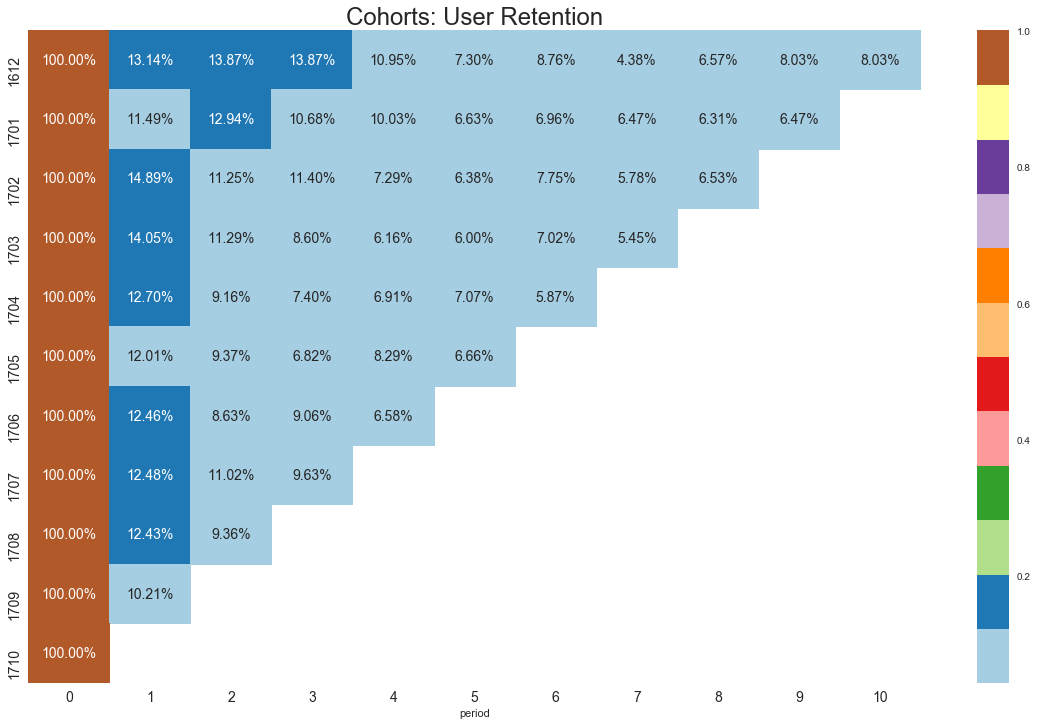

In [18]:
cohorts_usr.columns = ['1612', '1701', '1702', '1703', '1704', '1705',
                       '1706', '1707', '1708', '1709', '1710']
sns.set(style='white')
plt.figure(figsize=(20, 12))
plt.title('Cohorts: User Retention', size=24)
mat.rcParams.update({'font.size': 14})
plt.tick_params(labelsize=14)
sns.heatmap(cohorts_usr.T, mask=cohorts_usr.T.isnull(), annot=True, fmt='.2%', cmap='Paired')

## compute order retention by cohort

下列展示以訂單數為主要衡量回購基礎的算法，方法與上述相同，在此不贅述

In [19]:
cohorts_crt_group = cohorts['cart_code'].groupby(level=0).first()
cohorts_crt_group.head()

cohort_group
2016-12     140
2017-01     666
2017-02     699
2017-03    1389
2017-04    1370
Name: cart_code, dtype: int64

In [20]:
cohorts_crt = np.round(cohorts['cart_code'].unstack(0).divide(cohorts_crt_group, axis=1), 4)
cohorts_crt.head()

cohort_group,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10
period,,,,,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0
1,0.1786,0.1186,0.1745,0.1447,0.1350,0.1351,0.1417,0.1328,0.1326,0.1118,NaN
2,0.1429,0.1486,0.1230,0.1166,0.0942,0.1024,0.0927,0.1164,0.1004,NaN,NaN
3,0.2000,0.1141,0.1202,0.0878,0.0723,0.0697,0.0954,0.0976,NaN,NaN,NaN
4,0.1286,0.1156,0.0744,0.0634,0.0693,0.0853,0.0673,NaN,NaN,NaN,NaN


In [21]:
cohorts_crt.reset_index()

cohort_group,period,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10
0,0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0
1,1,0.1786,0.1186,0.1745,0.1447,0.1350,0.1351,0.1417,0.1328,0.1326,0.1118,NaN
2,2,0.1429,0.1486,0.1230,0.1166,0.0942,0.1024,0.0927,0.1164,0.1004,NaN,NaN
3,3,0.2000,0.1141,0.1202,0.0878,0.0723,0.0697,0.0954,0.0976,NaN,NaN,NaN
4,4,0.1286,0.1156,0.0744,0.0634,0.0693,0.0853,0.0673,NaN,NaN,NaN,NaN
5,5,0.1000,0.0691,0.0672,0.0619,0.0737,0.0704,NaN,NaN,NaN,NaN,NaN
6,6,0.1071,0.0691,0.0815,0.0756,0.0628,NaN,NaN,NaN,NaN,NaN,NaN
7,7,0.0571,0.0646,0.0587,0.0583,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,0.1000,0.0691,0.0658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,0.0929,0.0646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 劃出每個月訂單回購變化

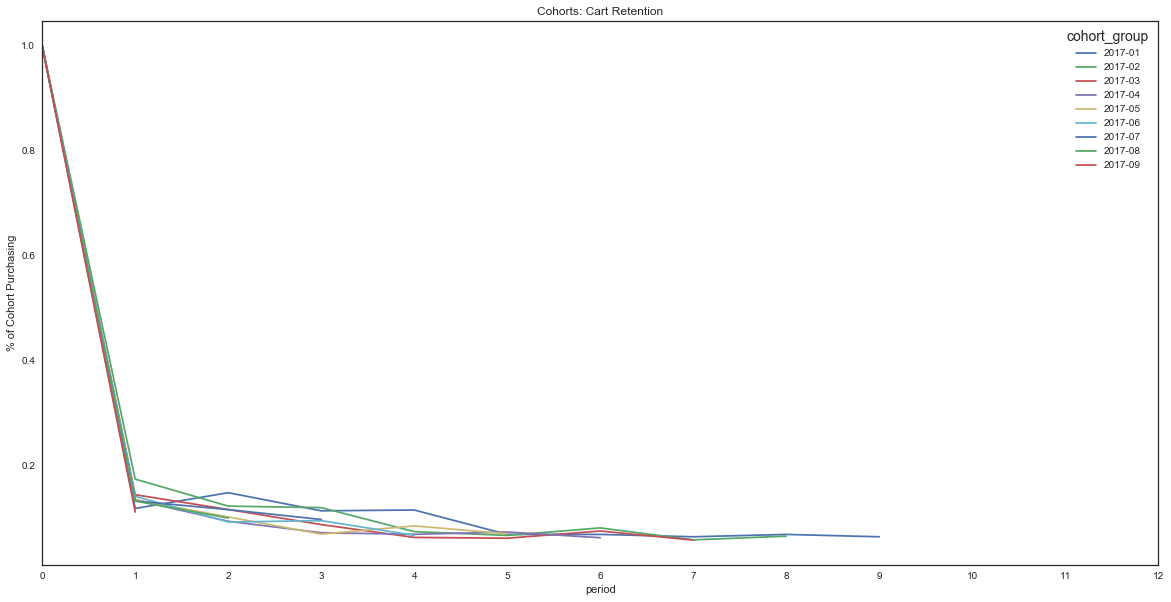

In [22]:
cohorts_crt[['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09']].plot(figsize=(20,10))
plt.title('Cohorts: Cart Retention')
plt.xticks(np.arange(0, 12.1, 1))
plt.xlim(0, 12)
#plt.ylim(0, 0.2)
plt.ylabel('% of Cohort Purchasing')

## 畫出以訂單為基準的cohort table

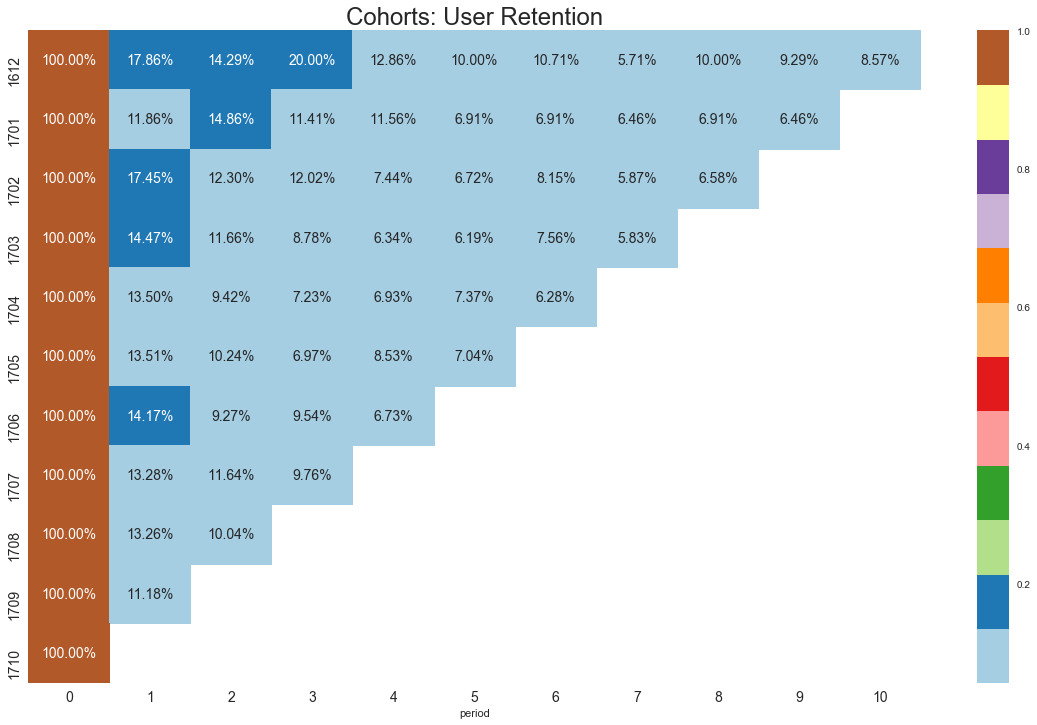

In [23]:
cohorts_crt.columns = ['1612', '1701', '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710']
sns.set(style='white')
plt.figure(figsize=(20, 12))
plt.title('Cohorts: User Retention', size=24)
mat.rcParams.update({'font.size': 14})
plt.tick_params(labelsize=14)
sns.heatmap(cohorts_crt.T, mask=cohorts_crt.T.isnull(), annot=True, fmt='.2%', cmap='Paired')

# 總結

Cohort analysis只是幫助你及早發現回購或顧客關係維持出狀況，因此這只是你分析的第一步！後續一般而言我還會進一步仔細研究以下差異，但礙於下列步驟會牽扯太多資訊，因此在此簡單條列給各位：
1. 觀察表現不好月份的購買商品排行，這部分還可以結合商品的回購率來比較
2. 觀察訂單的來源渠道，觀察這些渠道的變化，再進一步尋找是否該渠道的操作不同以往
3. 觀察表現不好的月份的廣告排名，觀察是否是新的廣告形式、族群、內容所導致的結果
4. 若你有做NPS，去觀察是否是服務、商品等原因導致消費者不回購
5. 觀察商城的產品狀況，如主打活動商品維和、庫存狀態和效期

最後希望這些步驟能幫助到需要回購分析的朋友，若要轉載再麻煩標明出處唷！